The Following is a pytorch implementation of the NeRF paper. The code is loosely based on the official NeRF github repo.

https://github.com/bmild/nerf/blob/master/tiny_nerf.ipynb



In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cpu")

In [3]:
def encode_points(points, dims=6):
    ret = [points]
    for L in range(dims):
        sin_enc = torch.sin(points*2**L)
        cos_enc = torch.cos(points*2**L)
        
        encoded_points = torch.cat((sin_enc, cos_enc), axis=-1)
        ret.append(encoded_points)
        
    ret = torch.cat(ret, axis=-1)
    return ret


In [4]:
def init_weights(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)


In [5]:
encode_points(torch.tensor([[0, 1]]), dims=4).shape

torch.Size([1, 18])

In [6]:
def get_viewdir(pose):
    point = torch.tensor([[0,0,1]], dtype=torch.float)
    P = pose[:3, :3]
    
    cartesian_point = P.matmul(point.reshape(3, 1)).reshape(3)
    normalized_point = cartesian_point / torch.sqrt(torch.sum(cartesian_point**2))
    
    theta, phi = torch.asin(cartesian_point[0]), torch.asin(cartesian_point[1])
    return theta, phi

In [7]:
def get_rays(W, H, focal, pose):
    P = pose[:3, :3]
    i,j = torch.meshgrid(torch.arange(0, W, dtype=torch.float), -torch.arange(0, H, dtype=torch.float))
    i = (i - W/2)/focal
    j = (j - H/2)/focal
    homogen_grid = torch.stack([i, -j, -torch.ones_like(i)], axis=-1).unsqueeze(2)
    
    ray_dirs = torch.sum(homogen_grid * P, axis=-1)
    ray_origins = pose[:3, -1].expand(ray_dirs.shape)
    return ray_origins, ray_dirs

In [8]:
def project_rays(ray_origins, ray_dirs, near=2.0, far=6.0, N_steps=40):
    # ray_origins of shape (W, H, 3)
    # ray_dirs of shape (W, H, 3)
    bin_size = (far-near+1)/N_steps
    W, H = ray_dirs.shape[0], ray_dirs.shape[1]
    ts = torch.arange(near, far+1, bin_size)
    ts = ts.reshape(-1, 1, 1).expand(-1, W, H)
    ts = ts + torch.tensor(np.random.uniform(size=ts.shape) * (far-near)/N_steps)

    rays = ray_origins + ray_dirs * ts.unsqueeze(-1).expand(-1, W, H, 3)
    rays = rays.permute(1, 2, 0, 3)
    ts = ts.permute(1, 2, 0)
    return rays.type(torch.float), ts.type(torch.float) #points, ts
    
    
    

In [57]:
class NeRF(torch.nn.Module):
    def __init__(self, point_encode_dims=6, angle_encode_dims=4):
        super(NeRF, self).__init__()
        self.point_encode_dims = point_encode_dims
        self.angle_encode_dims = angle_encode_dims
        self.point_dims = point_encode_dims*3*2
        self.angle_dims = angle_encode_dims*2*2
        
        self.fn1 = torch.nn.Linear(self.point_dims+3 , 500)
        self.fn2 = torch.nn.Linear(500, 500)
        self.fn3 = torch.nn.Linear(500, 500)
        self.fn4 = torch.nn.Linear(500, 500)


        #self.fn3 = torch.nn.Linear(500,)
        
        #self.color_net_1 = torch.nn.Linear(400, 200)
        self.color_net_fn1 = torch.nn.Linear(500 + self.angle_dims+2, 500)
        self.color_net_fn2 = torch.nn.Linear(500, 500)
        self.color_net_fn3 = torch.nn.Linear(500, 500)
        
        
        self.color_out = torch.nn.Linear(500, 3)
        self.density_out = torch.nn.Linear(500, 1)

        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
  
    def Block(self, x, layer, skip_connection=True):
        org_input = x
        x = layer(x)
        if skip_connection:
            ret = self.relu(x + org_input)
        else:
            ret = self.relu(x)
        return ret

        
    def forward(self, point, angle):
        density_input = point
        color_input = angle
        
        density_input = self.relu(self.fn1(point))
        hidden_state = self.relu(self.fn2(density_input))
        hidden_state = self.relu(self.fn3(hidden_state))
        
        hidden_state = hidden_state + density_input
        color_input = torch.cat([color_input,hidden_state], axis=-1)
        
        sigma = self.relu(self.density_out(hidden_state))
        
        color_input= self.relu(self.color_net_fn1(color_input))
        hidden_state = self.relu(self.color_net_fn2(color_input))
        hidden_state = self.relu(self.color_net_fn3(hidden_state))
        hidden_state = hidden_state + color_input
        
        color = self.sigmoid(self.color_out(hidden_state))
        
        
        return color, sigma
    
    def render_image_from_rays(self, rays, ts, angle, device=torch.device("cpu")):
        # rays of shape (W, H, N, 3)  where N = bins
        # ts of shape (W, H, N)
        # angle of shape (1, 2)
        W, H = rays.shape[0], rays.shape[1]
        N_steps = rays.shape[2]
        
        angle = angle.reshape(1, 1, 1, 2).expand(list(rays.shape[:-1]) + [2])
    
        rays_flat = encode_points(rays.reshape(-1, 3)).to(device)
        angles_flat = encode_points(angle.reshape(-1, 2), dims=4).to(device)
        #angle = torch.stack([encode_points(a) for a in angle], axis=0)
                
        #full_input = torch.cat((rays_flat, angles_flat), axis=-1)
        
        rgb_vals, sigmas = self.forward(rays_flat, angles_flat)
        sigmas = sigmas.reshape(100, 100, 40)
        rgb_vals = rgb_vals.reshape(100, 100, 40, 3)
        
        distances = torch.cat((ts[..., 1:] - ts[..., :-1], torch.broadcast_to(torch.tensor([1e10]), ts[...,:1].shape)), axis=-1)

        
        alpha = 1. - torch.exp(-sigmas*distances)
        #T_sigmas = torch.cat([torch.ones(100, 100, 1), sigmas], axis=-1)
        #T_deltas = torch.cat([torch.ones(100, 100, 1), distances], axis=-1)
        
        
        #T = torch.cumsum(T_sigmas*T_deltas, axis=-1)[:, :, :40]
        #T = torch.exp(-T)
        
        T = torch.cat([torch.ones(100, 100, 1), 1.-alpha+1e-10], axis=-1)
        T = torch.cumprod(T, axis=-1)[:, :, :40]
        
        weights = alpha *T 
        
        color = torch.sum(weights[...,None] * rgb_vals, axis=-2)
        img = color.reshape(W, H, 3)
        
        return img

In [58]:
data = np.load("tiny_nerf_data.npz")
poses = torch.tensor(data["poses"])
images = data["images"]
focal = data["focal"]
height, width = images.shape[1], images.shape[2]


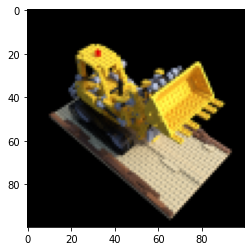

In [59]:
plt.imshow(images[101])

In [60]:
model = NeRF().to(device)
init_weights(model)

In [61]:
# test
ray_origins, ray_dirs = get_rays(width, height, focal, poses[0])
points, ts = project_rays(ray_origins, ray_dirs, N_steps=40)
angle = torch.tensor(get_viewdir(poses[0]))


In [62]:
img = model.render_image_from_rays(points, ts, angle, device=device).detach().numpy()


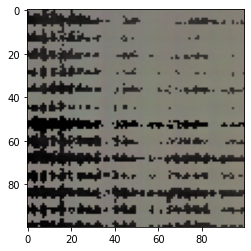

In [63]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(img)

In [64]:
class NeRFDataset(Dataset):
    def __init__(self, file="tiny_nerf_data.npz"):
        self.data = np.load(file)
        self.poses =  torch.tensor(self.data["poses"])
        self.images = torch.tensor(self.data["images"])
        self.focal = self.data["focal"]
        self.width, self.height = self.images.shape[1], self.images.shape[2]
        
    def __len__(self):
        return self.images.shape[0]
        
    def __getitem__(self, idx):
        img = self.images[idx]
        ray_origins, ray_dirs = get_rays(self.width, self.height, self.focal, self.poses[idx])
        rays, ts = project_rays(ray_origins, ray_dirs)
        theta, phi = get_viewdir(self.poses[idx])
        angle = torch.tensor([[theta, phi]])
        
        enc_ts = ts.reshape(-1, 40)
        enc_rays = rays.reshape(-1, 40, 3)
        enc_angle = angle.reshape(1, 1, 2).expand(enc_rays.shape[0], 40, 2)
        
        enc_rays = torch.stack([encode_points(r) for r in enc_rays], axis=0)
        enc_angle = torch.stack([encode_points(a) for a in enc_angle], axis=0)
        
        full_input = torch.cat((enc_rays, enc_angle), axis=-1)
        
        ret = {"data": [rays, ts, angle], "encoded": [enc_rays, enc_ts, enc_angle, full_input], "img": img}
        
        return ret

In [65]:
dataset = NeRFDataset()

In [66]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
Epochs = 2

In [67]:
ray_origins, ray_dirs = get_rays(width, height, focal, poses[101])
test_rays, test_ts = project_rays(ray_origins, ray_dirs, N_steps=40)
test_angle = torch.tensor(get_viewdir(poses[101]))
test_img = torch.tensor(images[101])

Epoch: 0


  0%|                                                  | 0/106 [00:00<?, ?it/s]

tensor(9.3677, grad_fn=<DivBackward0>)
Current Image


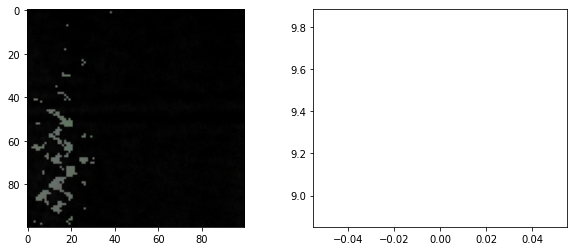

  9%|███▊                                     | 10/106 [05:20<50:31, 31.58s/it]

tensor(10.3508, grad_fn=<DivBackward0>)
Current Image


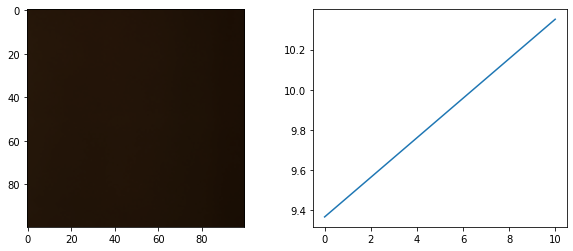

 19%|███████▋                                 | 20/106 [10:38<44:27, 31.02s/it]

tensor(10.8164, grad_fn=<DivBackward0>)
Current Image


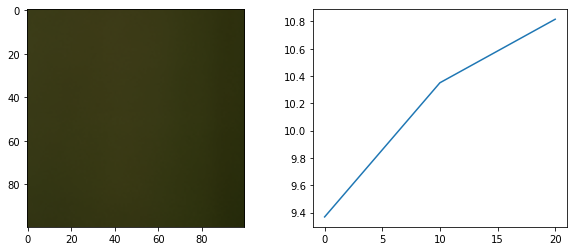

 28%|███████████▌                             | 30/106 [15:56<39:04, 30.85s/it]

tensor(10.7241, grad_fn=<DivBackward0>)
Current Image


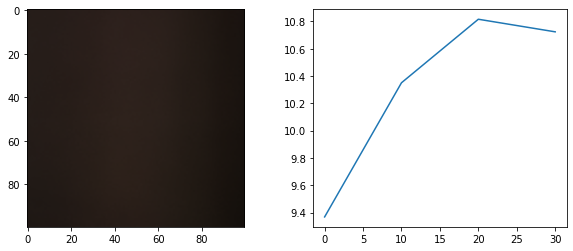

 38%|███████████████▍                         | 40/106 [21:16<34:13, 31.11s/it]

tensor(11.0337, grad_fn=<DivBackward0>)
Current Image


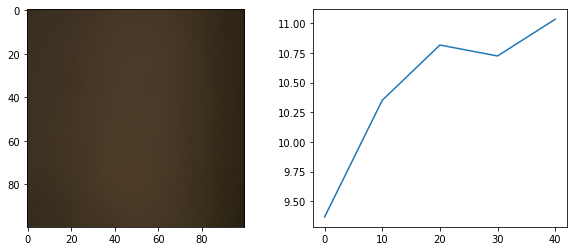

 47%|███████████████████▎                     | 50/106 [26:33<28:52, 30.94s/it]

tensor(11.1801, grad_fn=<DivBackward0>)
Current Image


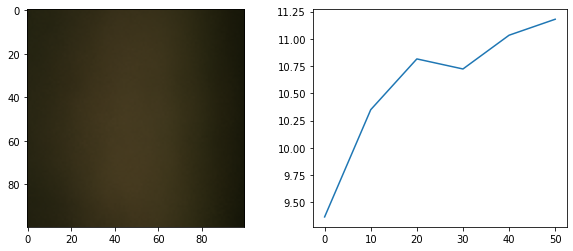

 57%|███████████████████████▏                 | 60/106 [31:51<23:42, 30.93s/it]

tensor(11.4195, grad_fn=<DivBackward0>)
Current Image


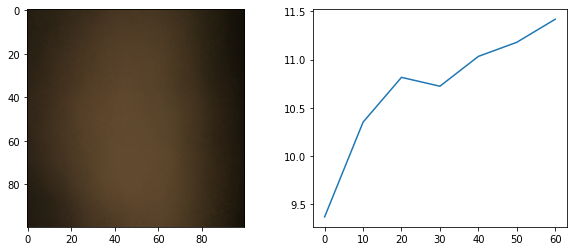

 66%|███████████████████████████              | 70/106 [37:10<18:38, 31.07s/it]

tensor(11.5940, grad_fn=<DivBackward0>)
Current Image


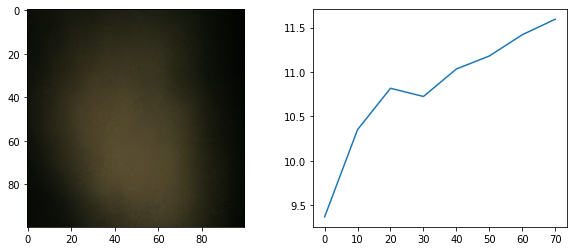

 75%|██████████████████████████████▉          | 80/106 [42:26<13:21, 30.83s/it]

tensor(11.6100, grad_fn=<DivBackward0>)
Current Image


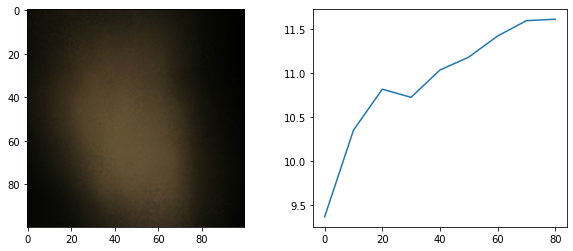

 85%|██████████████████████████████████▊      | 90/106 [47:42<08:11, 30.74s/it]

tensor(11.3669, grad_fn=<DivBackward0>)
Current Image


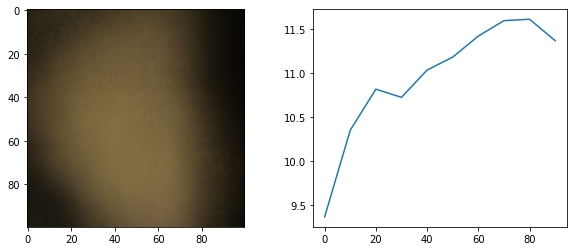

 94%|█████████████████████████████████████▋  | 100/106 [52:59<03:06, 31.03s/it]

tensor(11.7832, grad_fn=<DivBackward0>)
Current Image


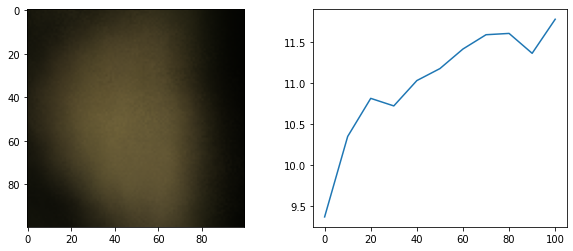

100%|█████████████████████████████████████| 106/106 [3:22:51<00:00, 114.83s/it]


Epoch: 1


  0%|                                                  | 0/106 [00:00<?, ?it/s]

tensor(11.6242, grad_fn=<DivBackward0>)
Current Image


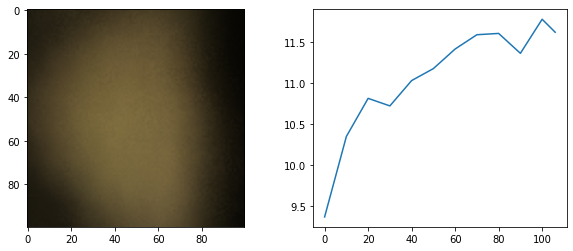

  8%|███▏                                      | 8/106 [04:38<54:34, 33.41s/it]

In [ ]:
# train
from tqdm import tqdm

loss_curve = []
iternums =[]

for e in range(Epochs):
    print("Epoch: %d" % e)
    indexes = np.arange(len(dataset))    # NOTE: TESTRANGE CHANGE!!!!!
    np.random.shuffle(indexes)
    
    for i in tqdm(range(len(dataset))):
        idx = indexes[i]
        X = dataset[idx]
        
        rays, ts, angle = X["data"]
        
        img = model.render_image_from_rays(rays, ts, angle)
        
        loss = torch.mean(torch.square(img - X["img"]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            iternums.append(i + e*len(dataset))
            img =  model.render_image_from_rays(test_rays, test_ts, test_angle)
            current_loss = torch.mean(torch.square(img - test_img))
            current_loss = -10 * torch.log(current_loss)/torch.log(torch.tensor(10))
            print(current_loss)
            loss_curve.append(float(current_loss))
            
            print("Current Image")
            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(img.detach().numpy())
            
            plt.subplot(122)
            plt.plot(iternums, loss_curve)
            plt.show()